### 1. GOAL
The goal of this task is to cluster keywords semantically with improvement in text cleansing. The data in previous clustering work still contains many irrelevant words which need to be removed to get resonable cluster result.

### 2. DATA
The data is from KW Clusters file https://docs.google.com/spreadsheets/d/1pDgWNNaEJqc7oNA8khVheK9uLX7Q6Bu-5L5BxBUoBJs/edit#gid=0 we use only the keywords column

### 3. TECHNIQUE SUMMARY
    3.1 Load data
    3.2 Tokenize and clean data
    3.3 Train word2vec on custom corpus
    3.4 Cluster keywords using K-Means
    3.5 Visualize clustering result
    3.6 Keywords analysis

### 3.1 Load Data

In [586]:
%matplotlib inline

import nltk.data
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases

from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

import pandas as pd
import numpy as np
from statistics import mean

import os
import re
import logging
import time
import sys
import multiprocessing
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from itertools import cycle

In [587]:
# get keywords column from KW Clusters excel file
df = pd.read_excel('kw_clusters.xlsx', sheetname='All')

C:\Users\user\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [588]:
df['keywords']

0      nectar  website | nectar  mattress store | nec...
1      nectar website  | bb website  | brooklyn beddi...
2      friend  | friend  referred | friend s | friend...
3      leesa  mattress | googled leesa  | leesa  and ...
4      yelp  | yelp , and then visited your new york ...
5      mattress stores  | mattress stores  nyc | bb s...
6      mom  group long island city | my mom  | mom  f...
7      mom group  long island city | facebook group  ...
8                            mom group long  island city
9                            mom group long island  city
10     mom group long island city  | google "new york...
11                                          neighborhood
12     casper  nyc | leesa and casper  showroom | mat...
13     where  to buy saatva bed | where  to try saatv...
14     where to buy  saatva bed | where can i buy  sa...
15     where to buy saatva  bed | where to try saatva...
16     googled brooklyn  bedding | brooklyn  bedding ...
17     winkbeds  | winkbeds  we

In [589]:
# convert the collective keywords with '|' delimiter to columns
# then transpose it to rows

df_keywords_split = df['keywords'].str.split("|",expand=True)

In [590]:
df_keywords_split

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,nectar website,nectar mattress store,nectar,googled nectar,nectar showroom,nectar try,nectar research,nectar mattress,where to try nectar,nectar show room,...,google nectar,nectar website chatroom,None,None,None,None,None,None,None,None
1,nectar website,bb website,brooklyn bedding website,helix website,winkbeds website,winkbed website,website reviews,winkbed website showed there was a showroom,saatva website,winks website,...,None,None,None,None,None,None,None,None,None,None
2,friend,friend referred,friend s,friend - word of mouth,friend referral,boyfriend,friend refer,a friend recommendation,referred by friend,friend,...,None,None,None,None,None,None,None,None,None,None
3,leesa mattress,googled leesa,leesa and casper showroom,leesa mattris,googling for leesa & purple show rooms,reddit- leesa reviews,leesa,leesa showroom,leesa mattress,leesa website,...,None,None,None,None,None,None,None,None,None,None
4,yelp,"yelp , and then visited your new york store a...",yelp mattress bed,yelp casper,yelp,mattress stores (yelp ),yelp mattress stores,leesa mattress yelp,None,None,...,None,None,None,None,None,None,None,None,None,None
5,mattress stores,mattress stores nyc,bb stores,best mattress stores,mattress stores on google maps,nectar stores,online bedding stores,google mattress stores new york city,matress stores near me,mattress stores testing,...,None,None,None,None,None,None,None,None,None,None
6,mom group long island city,my mom,mom facebook group upper east side mom s,mom s group facebook,your mom,mom,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,mom group long island city,facebook group,mom facebook group upper east side moms,moms group facebook,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,mom group long island city,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,mom group long island city,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [591]:
def transpose_keywords (df):
    df_rows_transpose = list()
    for idx in range(len(df)):
        df_row_transpose = df.iloc[idx].transpose()
        df_rows_transpose.append(df_row_transpose)
    df_keywords_transpose = pd.concat(df_rows_transpose)
    df_keywords_transpose = df_keywords_transpose.dropna()
    df_keywords_transpose = df_keywords_transpose.reset_index()
    df_keywords_transpose = df_keywords_transpose.drop(columns=['index'])
    df_keywords_transpose = df_keywords_transpose.rename(columns={0:"keywords"})
    return df_keywords_transpose

In [592]:
df_keywords = transpose_keywords(df_keywords_split)

In [593]:
df_keywords

,keywords
0,nectar website
1,nectar mattress store
2,nectar
3,googled nectar
4,nectar showroom
5,nectar try
6,nectar research
7,nectar mattress
8,where to try nectar
9,nectar show room


In [594]:
# save keywords to excel file
# df_keywords.to_excel('keywords.xlsx')

### 3.2 Tokenize and clean data
We manually remove rows of irrelevant keywords, fix spelling and remove duplicates. The irrelevant keywords can be found on sheet 'irrelevant_keywords' and spelling we fix on sheet 'fix_spelling'. Keywords with no irrelevants and right spelling is on sheet 'fix_keywords'. We also add new stopwords list by finding other irrelevant words in keyword phrases manually (sheet 'stopwords_addition'). Load it again later and then add it to current stopword list.

In [595]:
# add new words to current stopwords list
# load new stopwords
newStopwords = pd.read_excel('keywords.xlsx', sheetname='stopwords_addition')

In [596]:
# convert new stopwords dataframe to list
newStopwords = newStopwords.values.tolist()

In [597]:
newStopwords_list = list()
for list_stopwords in newStopwords:
    newStopwords_list.extend(list_stopwords)

In [598]:
# add new words to current stopwords list
stop_words = stopwords.words('english')
stop_words.extend(newStopwords_list)
stop_words = list(set(stop_words))

In [599]:
# load fix keywords from keywords excel file
df = pd.read_excel('keywords.xlsx', sheetname='fix_keywords')

In [600]:
# tokenize keywords
df["tokenized_keywords"] = df['keywords'].apply(nltk.word_tokenize)

In [601]:
df["tokenized_keywords"]

0                                       [nectar, website]
1                               [nectar, mattress, store]
2                                                [nectar]
3                                       [googled, nectar]
4                                      [nectar, showroom]
5                                           [nectar, try]
6                                      [nectar, research]
7                                      [nectar, mattress]
8                                [where, to, try, nectar]
9                    [google, -, nectar, mattress, store]
10                [online, ``, nectar, distributor, page]
11                                   [nectar, mattresses]
12                     [nectar, brick, and, motar, store]
13                               [online, ;, nectar, try]
14                               [purple, nectar, casper]
15                                       [nectar, stores]
16                          [google, nectar, and, purple]
17            

In [602]:
# convert dataframe to list of list
tokenized_keywords = df["tokenized_keywords"].values.tolist()

In [603]:
# Clean keywords
# Convert to lowercase
# Remove punctuation from each word
# Filter out remaining tokens that are not alphabetic
# Filter out tokens that are stop words
# lemmatization
def clean_text(list_tokens):
    #ps = PorterStemmer()
    word_lemma = WordNetLemmatizer()
    cleaned_tokens = list()
    for tokens in list_tokens:
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]
        # stemming
        # words = [ps.stem (w) for w in words]
        # lemmatize
        # nltk.download('wordnet')
        words = [word_lemma.lemmatize (w) for w in words]
        cleaned_tokens.append(words)
    return cleaned_tokens

In [604]:
# apply clean_text method to the tokenized_keywords
cleaned_keywords = clean_text(tokenized_keywords)

In [605]:
cleaned_keywords

[['nectar'],
 ['nectar', 'mattress', 'store'],
 ['nectar'],
 ['nectar'],
 ['nectar', 'showroom'],
 ['nectar', 'try'],
 ['nectar', 'research'],
 ['nectar', 'mattress'],
 ['try', 'nectar'],
 ['nectar', 'mattress', 'store'],
 ['nectar', 'distributor'],
 ['nectar', 'mattress'],
 ['nectar', 'brick', 'motar', 'store'],
 ['nectar', 'try'],
 ['purple', 'nectar', 'casper'],
 ['nectar', 'store'],
 ['nectar', 'purple'],
 ['nectar', 'matress'],
 ['nectar'],
 ['nectar'],
 ['nectar', 'showroom'],
 ['nectar', 'try'],
 ['try', 'nectar', 'mattress'],
 ['nectar', 'store'],
 ['nectar', 'nyc'],
 ['try', 'casper', 'nectar'],
 ['nectar', 'ecosa'],
 ['nectar', 'bed', 'ny'],
 ['nectar', 'bed'],
 ['nectar', 'mattress', 'nyc'],
 ['try', 'nectar'],
 ['try', 'nectar'],
 ['try', 'leesa', 'nectar'],
 ['nectar', 'brick', 'shed', 'motor'],
 ['nectar'],
 ['purple', 'nectar'],
 ['nectar'],
 ['nectar'],
 ['best', 'backpain', 'nectar'],
 ['purple', 'casper', 'nectar'],
 ['nectar', 'store', 'locator'],
 ['googlenectar', '

In [606]:
# remove empty list
cleaned_keywords_ = [list_keywords for list_keywords in cleaned_keywords if list_keywords != []]

In [607]:
cleaned_keywords_

[['nectar'],
 ['nectar', 'mattress', 'store'],
 ['nectar'],
 ['nectar'],
 ['nectar', 'showroom'],
 ['nectar', 'try'],
 ['nectar', 'research'],
 ['nectar', 'mattress'],
 ['try', 'nectar'],
 ['nectar', 'mattress', 'store'],
 ['nectar', 'distributor'],
 ['nectar', 'mattress'],
 ['nectar', 'brick', 'motar', 'store'],
 ['nectar', 'try'],
 ['purple', 'nectar', 'casper'],
 ['nectar', 'store'],
 ['nectar', 'purple'],
 ['nectar', 'matress'],
 ['nectar'],
 ['nectar'],
 ['nectar', 'showroom'],
 ['nectar', 'try'],
 ['try', 'nectar', 'mattress'],
 ['nectar', 'store'],
 ['nectar', 'nyc'],
 ['try', 'casper', 'nectar'],
 ['nectar', 'ecosa'],
 ['nectar', 'bed', 'ny'],
 ['nectar', 'bed'],
 ['nectar', 'mattress', 'nyc'],
 ['try', 'nectar'],
 ['try', 'nectar'],
 ['try', 'leesa', 'nectar'],
 ['nectar', 'brick', 'shed', 'motor'],
 ['nectar'],
 ['purple', 'nectar'],
 ['nectar'],
 ['nectar'],
 ['best', 'backpain', 'nectar'],
 ['purple', 'casper', 'nectar'],
 ['nectar', 'store', 'locator'],
 ['googlenectar', '

In [608]:
len(cleaned_keywords_)

1333

### 3.3 Train Word2Vec on Custom Corpus
We create Word2Vec model using our own data

In [609]:
start = time.time()

# set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# set values for various parameters
num_features = 50    # Dimensionality of the hidden layer representation
min_word_count = 1   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count()      # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       

# initialize and train the model
print("Training model...")
model = Word2Vec(cleaned_keywords_, workers=num_workers, size=num_features, min_count = min_word_count, window = context)

# save the model
model_name = "model_keywords"
model.save(model_name)

print('Total time: ' + str((time.time() - start)) + ' secs')

2020-01-14 09:01:30,691 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-01-14 09:01:30,692 : INFO : collecting all words and their counts
2020-01-14 09:01:30,693 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-14 09:01:30,695 : INFO : collected 253 word types from a corpus of 3012 raw words and 1333 sentences
2020-01-14 09:01:30,695 : INFO : Loading a fresh vocabulary
2020-01-14 09:01:30,697 : INFO : effective_min_count=1 retains 253 unique words (100% of original 253, drops 0)
2020-01-14 09:01:30,697 : INFO : effective_min_count=1 leaves 3012 word corpus (100% of original 3012, drops 0)
2020-01-14 09:01:30,699 : INFO : deleting the raw counts dictionary of 253 items
2020-01-14 09:01:30,700 : INFO : sample=0.001 downsamples 73 most-common words
2020-01-14 09:01:30,700 : INFO : downsampling leaves estimated 1294 word corpus (43.0% of prior 3012)
2020-01-14 09:01:30,702 : INFO : estimated required memory for 253 w

Training model...
Total time: 0.10597729682922363 secs


In [610]:
# vocabulary
list(model.wv.vocab)

['nectar',
 'mattress',
 'store',
 'showroom',
 'try',
 'research',
 'distributor',
 'brick',
 'motar',
 'purple',
 'casper',
 'matress',
 'nyc',
 'ecosa',
 'bed',
 'ny',
 'leesa',
 'shed',
 'motor',
 'best',
 'backpain',
 'locator',
 'googlenectar',
 'retail',
 'test',
 'manhattan',
 'brooklyn',
 'bedding',
 'helix',
 'winkbeds',
 'winkbed',
 'saatva',
 'wink',
 'airweave',
 'winkwebsite',
 'brookyln',
 'bear',
 'dreamcloud',
 'mattrees',
 'brookly',
 'friend',
 'referred',
 'referral',
 'boyfriend',
 'refer',
 'recommendation',
 'reference',
 'referal',
 'ahowroom',
 'salesman',
 'hybrid',
 'yelp',
 'visited',
 'roy',
 'testing',
 'matfress',
 'innerspring',
 'nest',
 'stomach',
 'sleeper',
 'nearby',
 'sleep',
 'mom',
 'group',
 'long',
 'island',
 'city',
 'facebook',
 'upper',
 'avocado',
 'sterling',
 'va',
 'representative',
 'nearest',
 'employee',
 'recommended',
 'tuft',
 'needle',
 'buy',
 'saatvs',
 'view',
 'puffy',
 'brentwood',
 'bloom',
 'hard',
 'retailer',
 'customer'

In [611]:
# create average feature embedding for each keyword phrase
def vectorizer(keyword_phrase, model_keywords):
    vec = list()
    num_keyword = 0
    for keyword in keyword_phrase:
        try:
            if num_keyword == 0:
                vec = model_keywords.wv[keyword]
            else:
                vec = np.add(vec, model_keywords.wv[keyword])
            num_keyword += 1
        except:
            pass
    return (np.array(vec)/num_keyword)

In [612]:
keywords_vec=list()
keywords_in_vocab=list()
for idx, key_phrase in enumerate(cleaned_keywords_):
    if len(vectorizer(key_phrase, model).tolist())!=0:
        keywords_vec.append(vectorizer(key_phrase, model).tolist())
        keywords_in_vocab.append(key_phrase)
    #else:
        #print(idx)
        
# convert list to ndarray
X=np.array(keywords_vec, dtype=object)

In [613]:
len(X)

1333

### 3.4 Cluster Keywords Using K-Means
We will cluster the keywords using KMeans. Since the keywords are represented as vectors, applying KMeans is easy to do since the clustering algorithm will simply look at differences between vectors (and centers).

In [614]:
def clustering_keywordvecs(keyword_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, max_iter = 100, init='k-means++')
    idx = kmeans_clustering.fit_predict(keyword_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

Text(0.5, 1.0, 'Elbow curve')

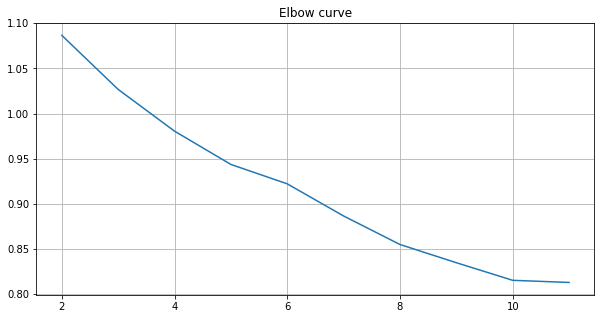

In [615]:
# get optimal k clusters
distorsions = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 12), distorsions)
plt.grid(True)
plt.title('Elbow curve')

As we cannot see the optimal k with elbow method, we can try another method called Silhouette method. The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation) -- Wikipedia. The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. The Silhouette Score reaches its global maximum at the optimal k. This should ideally appear as a peak in the Silhouette Value-versus-k plot. Here is the plot for our own dataset:

Text(0.5, 1.0, 'Elbow curve')

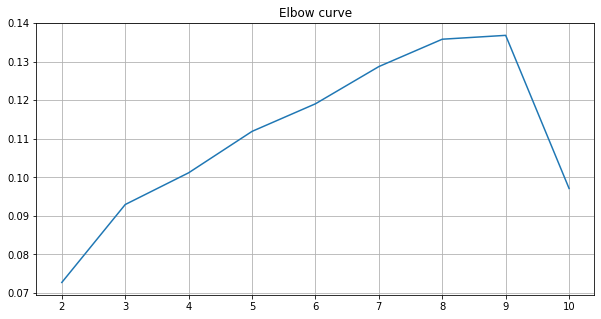

In [616]:
from sklearn.metrics import silhouette_score

silh = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    silh.append(silhouette_score(X, labels, metric = 'euclidean'))
    
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silh)
plt.grid(True)
plt.title('Elbow curve')

In [617]:
# apply KMeans clustering to the keywords data with K=9
centers, clusters = clustering_keywordvecs(X, 9)

In [618]:
# assign list keywords of each cluster to variables
#keywords_cluster_0 = list()
#keywords_cluster_1 = list()
#keywords_cluster_2 = list()
#keywords_cluster_3 = list()
cluster_dict = dict()
for index, keyword_vector in enumerate(keywords_in_vocab):
    try:
        #print(str(clusters[index]) + ":" + ' '.join(keyword_vector))
        cluster_dict.update({' '.join(keyword_vector) : str(clusters[index])})
        #if clusters[index] ==0:
            #keywords_cluster_0.extend(keyword_vector)
        #elif clusters[index] ==1:
            #keywords_cluster_1.extend(keyword_vector)
        #elif clusters[index] ==2:
            #keywords_cluster_2.extend(keyword_vector)
        #else:
            #keywords_cluster_3.extend(keyword_vector)       
    except IndexError:
        pass
print(cluster_dict)

{'nectar': '7', 'nectar mattress store': '1', 'nectar showroom': '7', 'nectar try': '7', 'nectar research': '7', 'nectar mattress': '1', 'try nectar': '7', 'nectar distributor': '7', 'nectar brick motar store': '5', 'purple nectar casper': '7', 'nectar store': '7', 'nectar purple': '7', 'nectar matress': '7', 'try nectar mattress': '1', 'nectar nyc': '7', 'try casper nectar': '0', 'nectar ecosa': '7', 'nectar bed ny': '7', 'nectar bed': '7', 'nectar mattress nyc': '1', 'try leesa nectar': '7', 'nectar brick shed motor': '7', 'purple nectar': '7', 'best backpain nectar': '7', 'purple casper nectar': '7', 'nectar store locator': '5', 'googlenectar retail': '0', 'leesa nectar showroom': '7', 'nectar showroom nyc': '8', 'mattress nyc try leesa casper nectar': '0', 'nectar mattress test': '1', 'casper purple nectar': '7', 'try nectar manhattan': '7', 'leesa nectar': '7', 'casper nectar': '7', 'brooklyn bedding': '2', 'helix': '0', 'winkbeds': '6', 'winkbed': '4', 'winkbed showroom': '4', 's

In [619]:
df_keyword_cluster = pd.DataFrame([cluster_dict]).T

In [620]:
df_keyword_cluster

,0
address,8
air weave,0
air weave dealer,0
air weave mattress,1
air weave partner,0
air weave showroom,8
airweave,6
airweave dealer,6
airweave mattress,1
airweave partner,6


In [621]:
# create column name and sort based on cluster
df_keyword_cluster = df_keyword_cluster.rename(columns={0:"clusters"})
df_keyword_cluster = df_keyword_cluster.sort_values(by=['clusters'])

In [622]:
df_keyword_cluster

,clusters
nearby,0
casper mattress nyc,0
casper mattress map,0
helix,0
casper matress nyc,0
tuft needle referred,0
casper employee,0
casper avocado sterling va,0
casper,0
try dreamcloud,0


In [623]:
# save cluster result to excel file
# df_keyword_cluster.to_excel('cluster_result.xlsx')